In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import math

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm.autonotebook import tqdm

from utils import general_utils
from utils import eval_utils
from deformation import losses

In [46]:
#class_ids = ["test"]
class_ids = ["02691156", "02828884", "02933112", "02958343", "03001627", "03211117", "03636649", "03691459", "04090263", "04256520", "04379243", "04401088", "04530566"]
sym_results_df = pd.DataFrame()
for class_id in tqdm(class_ids):
    sym_results = pickle.load(open("data_prep_tools/check_symmetry_results/{}.p".format(class_id), "rb"))
    for path in sym_results:
        instance = path.split('/')[-2]
        sym_loss = sym_results[path]
        entry_dict = {"class": class_id, "instance": instance, "sym_loss": sym_loss}
        sym_results_df = sym_results_df.append(entry_dict, ignore_index=True)

In [47]:
display(sym_results_df.sort_values("sym_loss", ascending=False))

,class,instance,sym_loss
28069,04379243,3712e31c61ea51a354b250a5bdfb0136,3.243314e-02
29585,04379243,f5d87f88bd9b31ad2f0ebd444c10bd0c,3.227737e-02
26276,04379243,ec9861c234daf6bc915f51b5f5e95ffa,3.225997e-02
27265,04379243,f7ced3de6f4c1ffb4e3935c6cee4b35,3.106036e-02
19427,04256520,d58a2c86b9b71f6bef4e42d70375aed8,3.009399e-02
...,...,...,...
12324,03211117,23c99db82c910931e2c8e43c97ec5a85,3.238814e-05
12144,03211117,877cadd597775369ec059109909662d2,2.567960e-05
31378,04401088,ef2b505068cf120efe48f52a0ccc160d,2.432552e-05
12565,03211117,aa99cc4323af7144e7321f25048c6142,1.955101e-05


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3db5f27908>]],
      dtype=object)

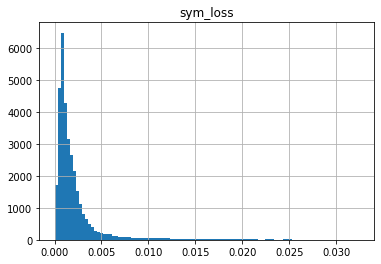

In [48]:
sym_results_df.hist(column="sym_loss", bins=100)

In [49]:
for class_id in class_ids:
    n = len(sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)])
    print("{} -- {}".format(class_id, n))

02691156 -- 9
02828884 -- 36
02933112 -- 3
02958343 -- 14
03001627 -- 19
03211117 -- 7
03636649 -- 47
03691459 -- 57
04090263 -- 16
04256520 -- 569
04379243 -- 369
04401088 -- 15
04530566 -- 17


02691156 -- 9e998a06601e9f944b2bd73664dd1844 -- 0.014857470989227295


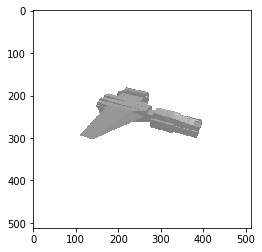

02691156 -- b2960c2be8fad9dac140e34b6af37a1d -- 0.0142524978145957


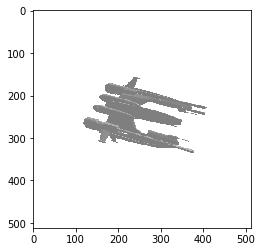

02691156 -- 43c5f85e9a10071cb1bb46d2556ba67d -- 0.012968356721103191


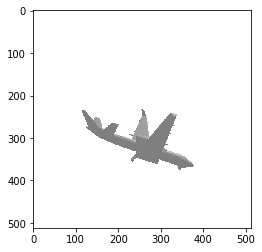

02691156 -- 26210ec84a9c1c6eb1bb46d2556ba67d -- 0.011847294867038727


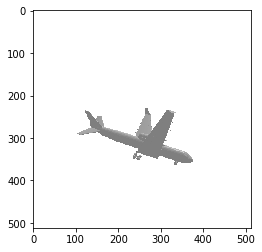

02691156 -- 5eb91263da1f0bf3e816c75152573ee0 -- 0.011640879325568676


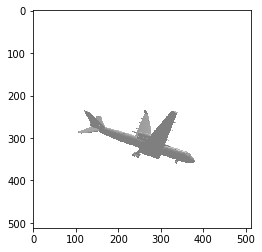

02691156 -- 7c76d7d8ecfca9c2b1bb46d2556ba67d -- 0.01093309372663498


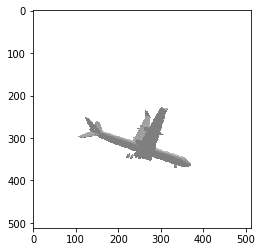

02691156 -- a12179d6f8b753a934a446df7eff04e9 -- 0.010603553615510464


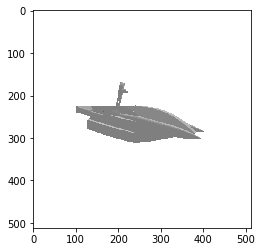

02691156 -- ebd96d07a7d68cf2fc7b6f7beb3a27ff -- 0.010567727498710155


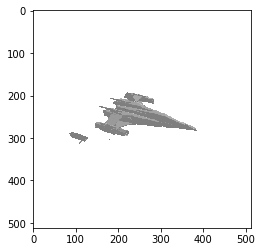

02691156 -- 7ee59463dc17ac6e3e3f3c9608255377 -- 0.010396343655884266


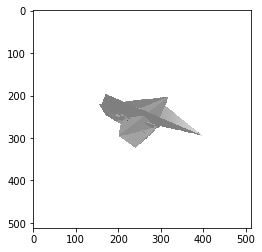

02828884 -- a82c14ef1540d3abf4c42dc386169bd6 -- 0.02398495376110077


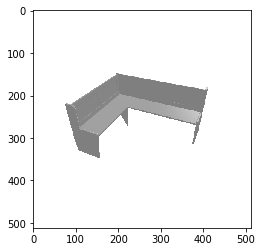

02828884 -- f9e7dcaf9b7a9eb3c9befbd10d7e29b -- 0.02327362261712551


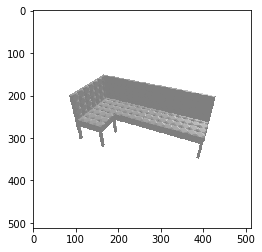

02828884 -- 6b894c1c57ba921c98d10ca8df5ecbe7 -- 0.021441467106342316


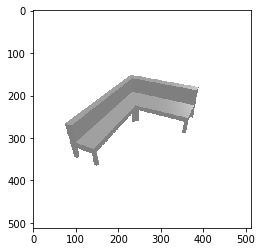

02828884 -- 3dec9b1439c42797815b2b467e8e2eac -- 0.01981166936457157


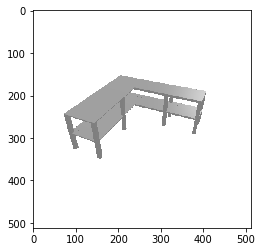

02828884 -- 36e1592e13b4f5ed569c11df1aea8ca4 -- 0.01922186277806759


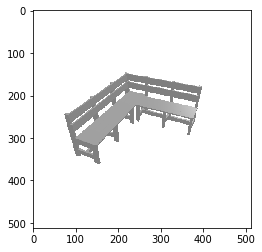

02828884 -- 30b57b828f961ca8f002715a08c57858 -- 0.01816508173942566


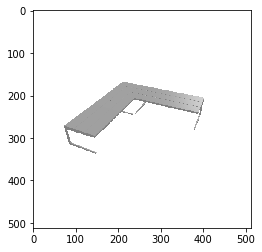

02828884 -- 76958ab9aa25d309c9eed7651b77d0f -- 0.018044842407107353


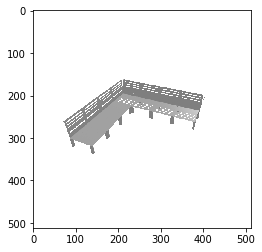

02828884 -- f7ffdf91b66c0c989c9513cebb0fb44c -- 0.016172777861356735


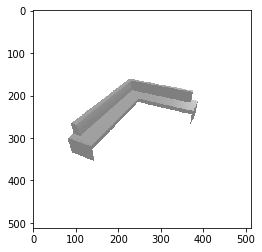

02828884 -- 5ce845f80b1d407282dde982679cd879 -- 0.01584465056657791


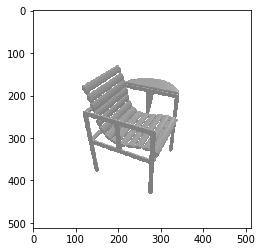

02828884 -- a4491b4a67356be5184c1614f4105c8b -- 0.015770558267831802


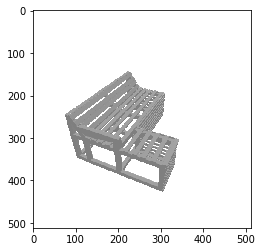

02828884 -- b58a0307a86959bd564f6f5de611dfed -- 0.0155298737809062


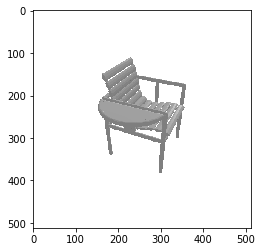

02933112 -- 79a8b5fdd40e1b1d20768660cf080d12 -- 0.02121858112514019


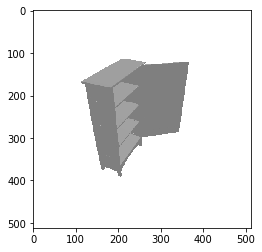

02933112 -- 5ff47fe4724d0c9320768660cf080d12 -- 0.015382437035441399


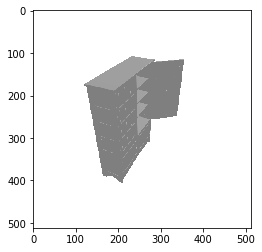

02933112 -- eb2843ff62280f5320768660cf080d12 -- 0.013308195397257805


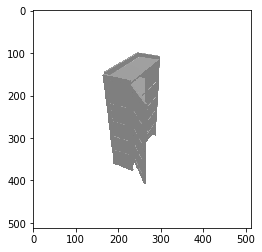

02958343 -- 49221c9b78d4f1f7f5811df876151dc9 -- 0.028181064873933792


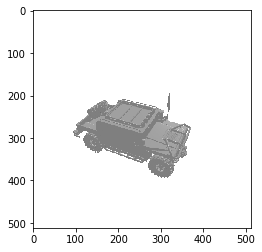

02958343 -- a4642330e9cfd4377c8cd0db4eab63cd -- 0.026446498930454254


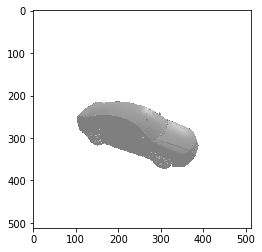

02958343 -- 52c589e86fd500cd4a42886683bb52d2 -- 0.024864543229341507


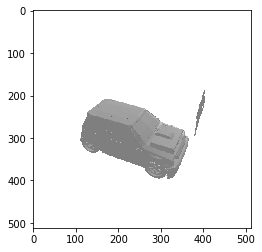

02958343 -- 59b5d8f034ae41c460788c0328f6bc39 -- 0.02392677217721939


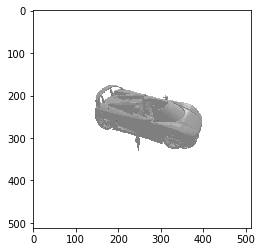

02958343 -- 2d6c360e7d8ff4162e603610d34efc63 -- 0.017531229183077812


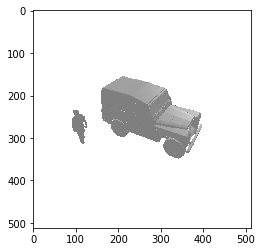

02958343 -- b2b2f4952e4068d955fe55d6e406ecd4 -- 0.016140403226017952


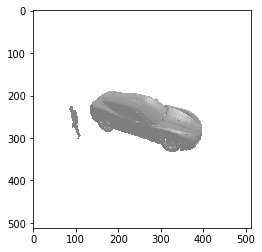

02958343 -- 2a9769287275936798494085d68ad6a0 -- 0.016083218157291412


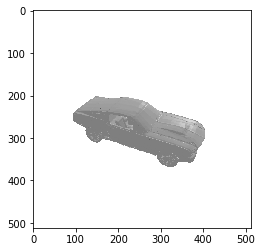

02958343 -- f76df2076c3af2b61244a04f5190e0a -- 0.01479779090732336


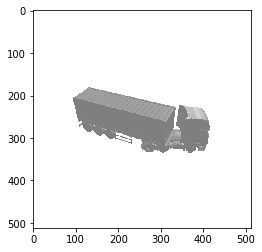

02958343 -- 7a4d80c0041fbb4beb7d3be79f91e024 -- 0.013920536264777184


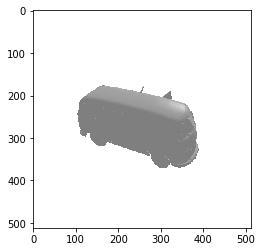

03001627 -- 7eb4a453070b3f090d1267f8054d8a8 -- 0.01940469816327095


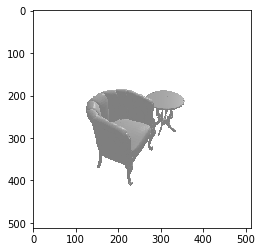

03001627 -- 71b1134533fb33f489452a0032ea575 -- 0.01621316932141781


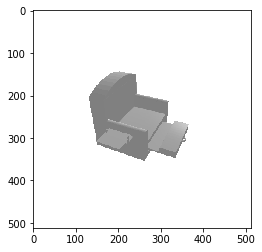

03001627 -- 5ce845f80b1d407282dde982679cd879 -- 0.01584465056657791


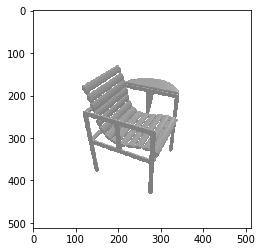

03001627 -- 17dee0cfe9a370b134bce1184e175df4 -- 0.012758554890751839


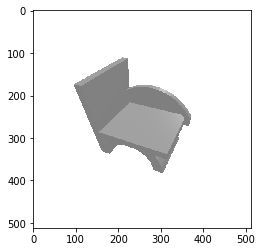

03001627 -- 8e1f9f4e3cd226bacb916d8f4f1ff996 -- 0.01270240917801857


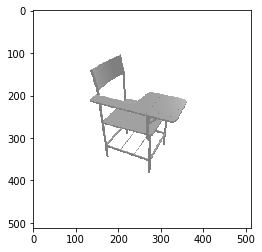

03001627 -- 6b4622c4e15b5cc9f91663a74ccd2338 -- 0.012574918568134308


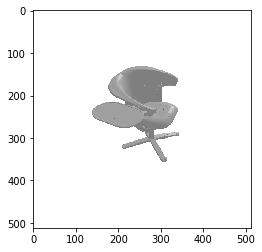

03001627 -- fd5f6ed4a873c5ec300fe8666348bd38 -- 0.011392518877983093


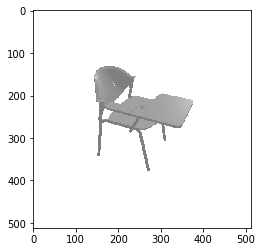

03001627 -- 6c72077d968519bc13e020d985215e3 -- 0.010927545838057995


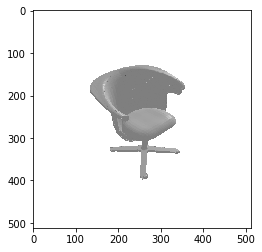

03001627 -- 9e6564dce4cc128efc24661f5f8d5d00 -- 0.010762128978967667


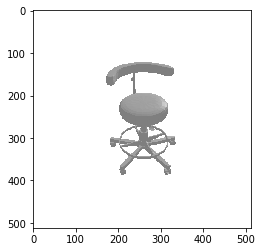

03001627 -- 32b7f9324c56d6131b02cde7e81f0fc3 -- 0.010639123618602753


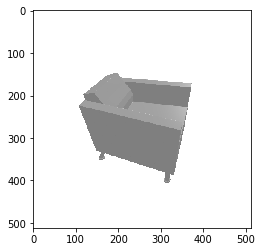

03211117 -- 252640ae350a1e53f119712971a6882c -- 0.022525351494550705


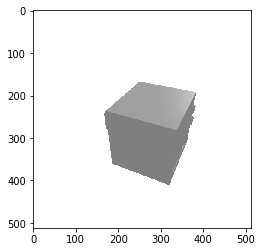

03211117 -- bd3df021605a8aa24c619b8a18eba62d -- 0.019336842000484467


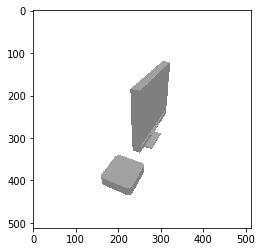

03211117 -- ac2ea2d41c57d1075999f9ba82d15928 -- 0.01695428416132927


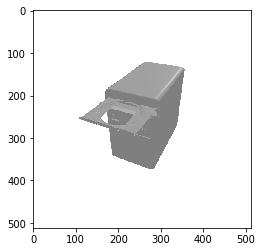

03211117 -- 977da77136819715cf8a1b5af7e0bc1d -- 0.012432086281478405


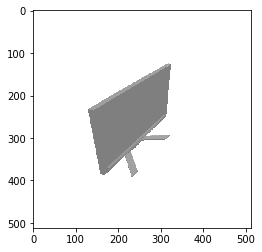

03211117 -- 2bbf7f77d43b74338a331b18e58c6914 -- 0.01214580424129963


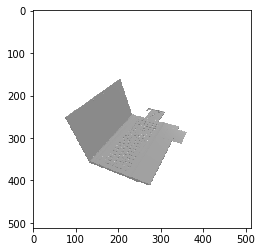

03211117 -- d5b088ccd7d1a7ba8e2d66cbf6a91063 -- 0.01131383329629898


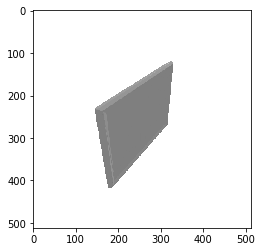

03211117 -- 30e739ed4c65f67ab71158027becbea8 -- 0.010503711178898811


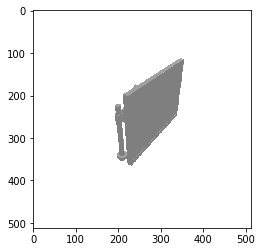

03636649 -- e7b719516449701362525a4d857f099d -- 0.01915653422474861


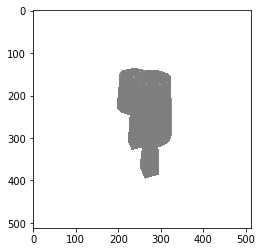

03636649 -- dd40743536da78a2bf964fc57f6a7d6d -- 0.01682266592979431


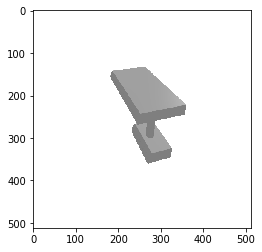

03636649 -- d2d645ce6ad43434d42b9650f19dd425 -- 0.01669285260140896


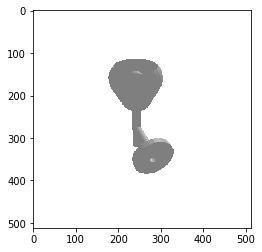

03636649 -- f330eebb153447181735ea0e092a805a -- 0.016623472794890404


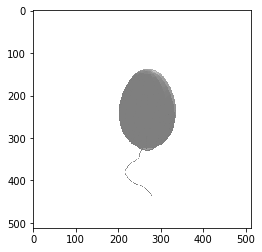

03636649 -- 7124fa42397a447c34db027e489e649e -- 0.01607465371489525


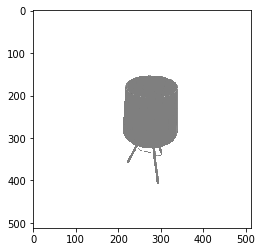

03636649 -- d5a67642ff0a2908dbfbef883e8d10aa -- 0.013201465830206871


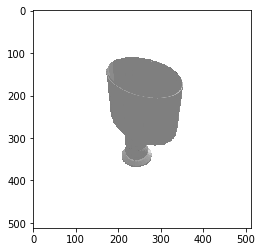

03636649 -- 270ec239221938991735ea0e092a805a -- 0.013171553611755371


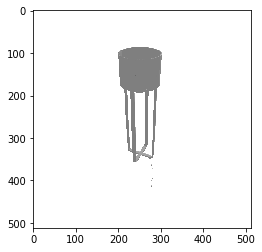

03636649 -- b2acbb6717c7a842fcb8d8c6d4df8143 -- 0.013158407062292099


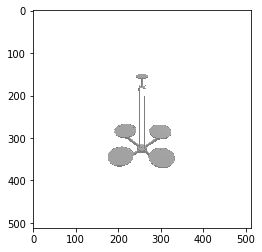

03636649 -- e487374a244b5f03b428462f49e66329 -- 0.012615025043487549


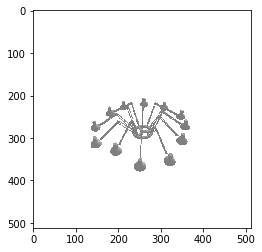

03636649 -- fdc4b403601fedf955b7716fb9f91d35 -- 0.012589706107974052


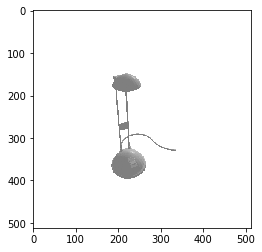

03636649 -- f5a48805f020d3e3967cdbf1c849239 -- 0.012177678756415844


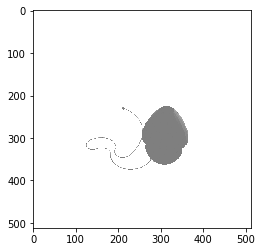

03691459 -- 8aea25f1090e419c9f78b1e1185445c4 -- 0.026223793625831604


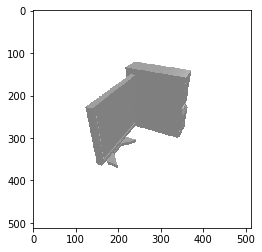

03691459 -- 5394ceacb131b5e79d7aee0f8e107545 -- 0.01905793324112892


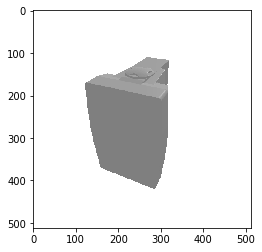

03691459 -- 6803540650949be89c4081063e213a15 -- 0.0186004675924778


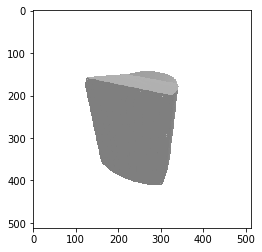

03691459 -- 552dd48f9a264d721574d21c0c95092f -- 0.018401771783828735


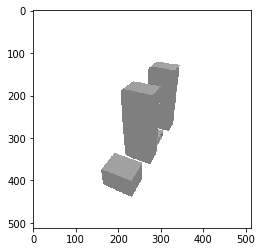

03691459 -- fad354295b4c0fdb55266ce6303fe1e0 -- 0.01791972853243351


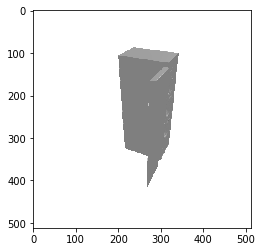

03691459 -- 453c959963a529322633ff66beb9cf31 -- 0.01791345700621605


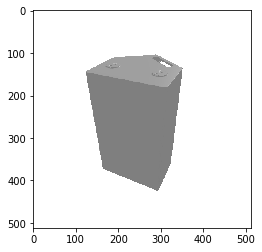

03691459 -- 221a981adf503875e17b9e33c097dbff -- 0.01750200055539608


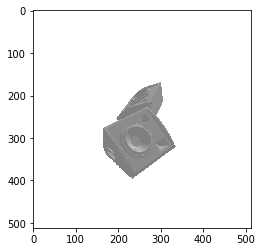

03691459 -- eb9de225b5d502c1278fe505f40d50be -- 0.01650245115160942


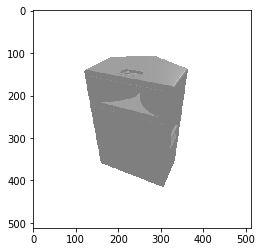

03691459 -- a3d5207350bdc01e87d57ccb715c57f5 -- 0.01597854122519493


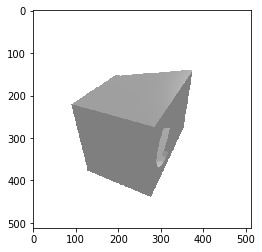

03691459 -- 68d5652dfb91b82fa2b4280235a76885 -- 0.015965161845088005


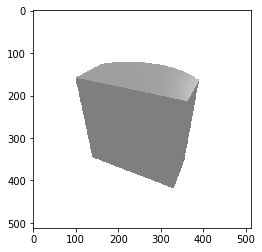

03691459 -- 29faf5a7c444df58a1fabddca717cbad -- 0.014681845903396606


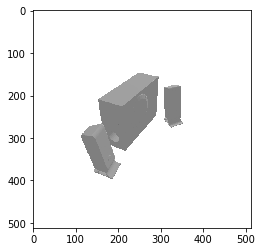

04090263 -- 2a45063d7d03b865ebeab56de94a5835 -- 0.014833852648735046


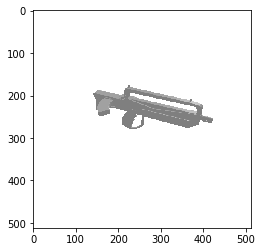

04090263 -- 235853d2947a90e65e9786b1603f45c8 -- 0.014586306177079678


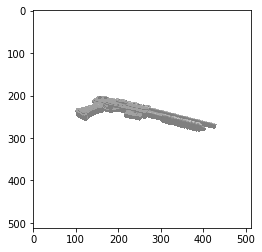

04090263 -- 36dee5893da238565dca6305fb9f97ca -- 0.013163650408387184


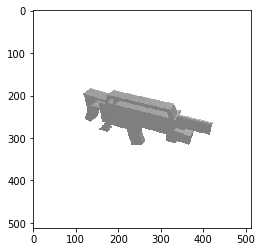

04090263 -- 3a8526095bae7e553c79ad8cab094d8 -- 0.01274330448359251


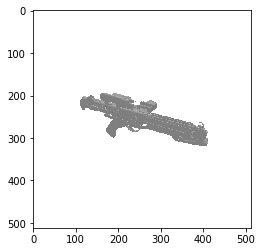

04090263 -- 1fa2cbd03c1d57829f7e0a8a6309376 -- 0.01218157634139061


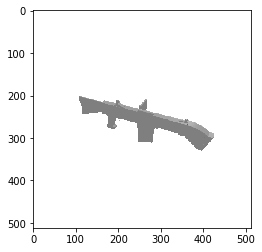

04090263 -- 91b0c8975ce241d69557371cff545901 -- 0.011643136851489544


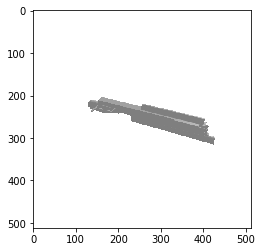

04090263 -- d9f1cee28bd9a88c2f2258791e7c116a -- 0.011586318723857403


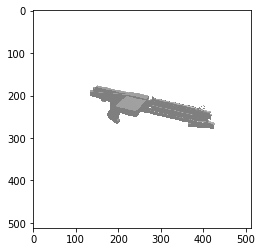

04090263 -- cfd06e58d354213c8f2a8ddb5c970b6 -- 0.01150974165648222


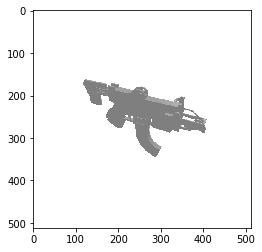

04090263 -- 190ce4466c6f4c04fa9286f039319ff7 -- 0.011078011244535446


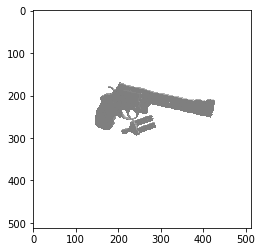

04090263 -- 809d2439412bcdac896cb6094e2801d6 -- 0.01099972054362297


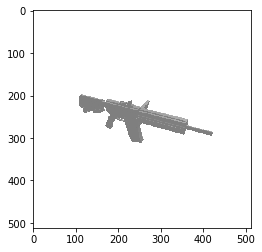

04090263 -- 84de9995b0a416b5fb5c1b0f759e2bc1 -- 0.0109420670196414


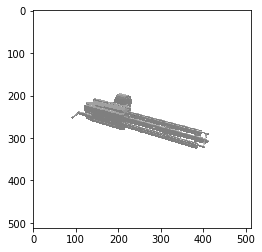

04256520 -- d58a2c86b9b71f6bef4e42d70375aed8 -- 0.03009398840367794


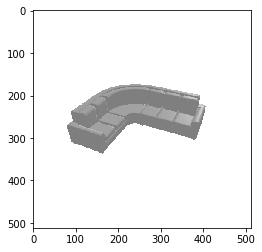

04256520 -- 1193da9a06f87fd6a0064771a6f2cf3b -- 0.029097657650709152


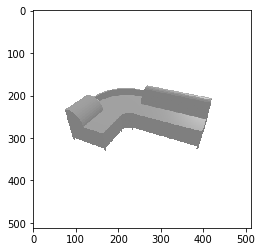

04256520 -- 64c8591e8a837cd5dc8d41086ec55d96 -- 0.02899174764752388


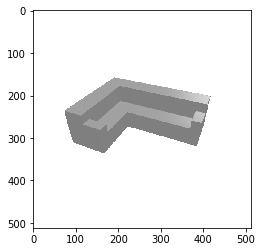

04256520 -- 575876c91251e1923d6e282938a47f9e -- 0.028169646859169006


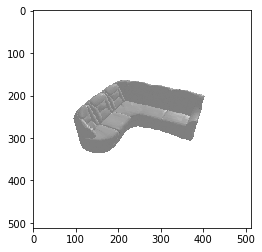

04256520 -- 664a84b65396e168707aff99601b0e71 -- 0.02805207297205925


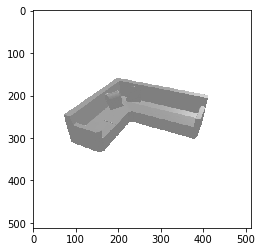

04256520 -- 96055e2a648903bbaf2302630d34f30e -- 0.02801472507417202


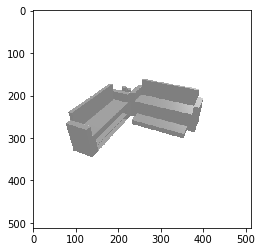

04256520 -- 7b9d9c738c6042ad1c2c02171f63f02f -- 0.0276789553463459


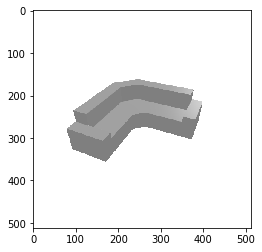

04256520 -- b4a72257eff26336d7231c5bdc5ab135 -- 0.027665644884109497


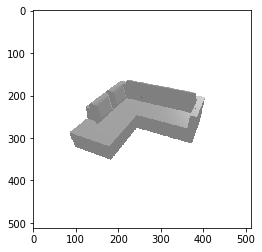

04256520 -- 16fd88a99f7d4c857e484225f3bb4a8 -- 0.02759621851146221


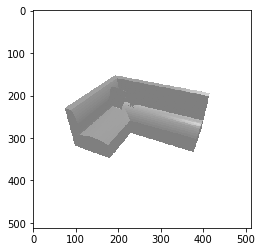

04256520 -- 19f0a14207f4f953bb1b55ae5bd11e93 -- 0.02747318521142006


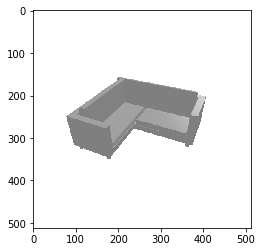

04256520 -- e68e91ef2652cd1c36e3b2fa8d1eb4eb -- 0.02725428156554699


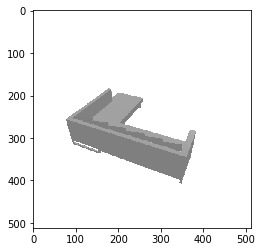

04379243 -- 3712e31c61ea51a354b250a5bdfb0136 -- 0.03243314474821091


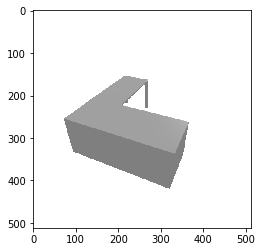

04379243 -- ec9861c234daf6bc915f51b5f5e95ffa -- 0.032259970903396606


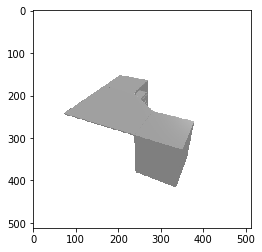

04379243 -- f7ced3de6f4c1ffb4e3935c6cee4b35 -- 0.0310603566467762


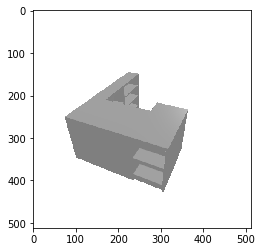

04379243 -- 7b3dfbd70333485d219a1300d9489f4e -- 0.029440313577651978


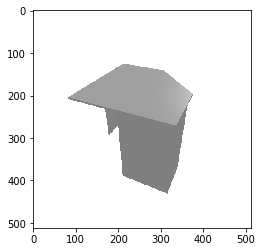

04379243 -- 33486ab58b77ea46768449c155e32d73 -- 0.028912555426359177


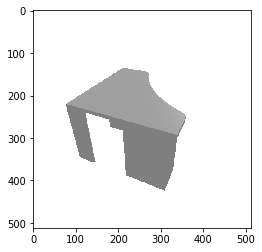

04379243 -- c9ad84452fe0ece05ab833c88a8efb15 -- 0.0287475548684597


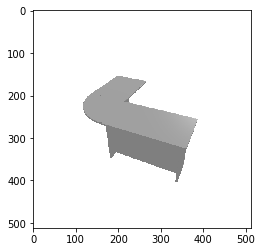

04379243 -- c74ea23fce212291943df36e40894fd9 -- 0.028430797159671783


KeyboardInterrupt: 

In [41]:
device = torch.device("cuda:0")
shapenet_dir = "/home/svcl-oowl/dataset/ShapeNetCore.v1"
dist = 1.3
elev = 35
azim = 25
R, T = look_at_view_transform(dist, elev, azim) 
num_show = 10


for class_id in class_ids:
    i = 0
    for _, row in sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)].sort_values("sym_loss", ascending=False).iterrows():
        class_id = row["class"]
        instance = row["instance"]
        sym_loss = row["sym_loss"]
        print("{} -- {} -- {}".format(class_id, instance, sym_loss))
        
        model_path = os.path.join(shapenet_dir, class_id, instance, "model_watertight.obj")
        mesh = general_utils.load_untextured_mesh(model_path, device)
        render = general_utils.render_mesh(mesh, R, T, device)
        plt.imshow(render[0, ..., :3].detach().cpu().numpy())
        plt.show()
        
        i+=1
        if i > num_show:
            break
        
    



In [51]:
# create lists

output_dir = "data_prep_tools/occnet_test_set_lists"
shapenet_dir = "/home/svcl-oowl/dataset/ShapeNetCore.v1"

num_save = 20

for class_id in class_ids:
    i = 0
    with open(os.path.join(output_dir, "sym_{}.lst".format(class_id)), "w") as f:
        for _, row in sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)].sort_values("sym_loss", ascending=False).iterrows():
            instance = row["instance"]
            f.write("{}\n".format(instance))

            i+=1
            if i >= num_save:
                break
        